# ENCODE bigWig analysis questions

Do your best to answer all parts of each question. You are encouraged to work in pairs. 

Answers to many questions may benefit from using more than one cell, as well as a combination of markdown and code cells.

Put helper functions into a separate script (e.g. `hwutils.py`) so they can be commented on easily and focus the notebook on plotting. Also see the [workshop on Clean Code](https://drive.google.com/file/d/1TraVwRkbkCbHq-s_-NS69ZEbRNwH8XNh/view) from Dan Larremore (https://larremorelab.github.io/slides/) for good coding tips to use in this assignment.


In [1]:
# useful libraries to import
import pandas as pd
import numpy as np
import random as rand

import  sklearn.decomposition
import sklearn.manifold

import matplotlib.pyplot as plt
from matplotlib.ticker import EngFormatter
bp_formatter = EngFormatter('b') 
# nice way to format ticks as human-readable: ax.xaxis.set_major_formatter(bp_formatter)

from hwutils import *

In [2]:
# load dataFrame of bigWigs from ENCODE (encodeproject.org/), binned to 10kb resolution across chromosome 10.
# note that the first three columns are chrom,start,end and the other columns are labeled by bigWig file accession.
df = pd.read_table('./data/ENCODE_GRCh38_binned_subset.tsv')

# load metadata from ENCODE for bigwig files. 
# can be queried as follows: bigwig_metadata.query("`File accession`==@ df_column_name ")
bigwig_metadata = pd.read_table('./data/ENCODE_GRCh38_bigWig_metadata.tsv')

/var/folders/ll/3l914f0s73jg8kypspvjvm3c0000gn/T/ipykernel_19056/1708817607.py:7: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  bigwig_metadata = pd.read_table('./data/ENCODE_GRCh38_bigWig_metadata.tsv')


- After loading the data (above), and visualize some of the profiles. Why might many signals dip on chr10 at around 40Mb?


<AxesSubplot: xlabel='midpos'>

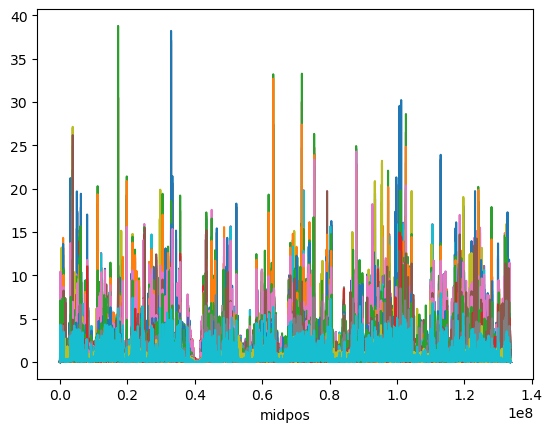

In [3]:
# Plotting the reads across all profiles
df['midpos'] = (df.start + df.end)/2
df.iloc[:, 3:].set_index('midpos').plot(legend=False)

From the plot above, we saw that many signals dip around 40Mb on Chr10. This might because the centromere is located around that position. Chromosomes are extremely repetitive regions that are never translated as far as we know. The other possibility could be some conserved region of permanent heterochromatin? But I find that somewhat unlikely.

- Use scikit-learn to perform PCA, and make a scatterplot of PC1 vs PC2.


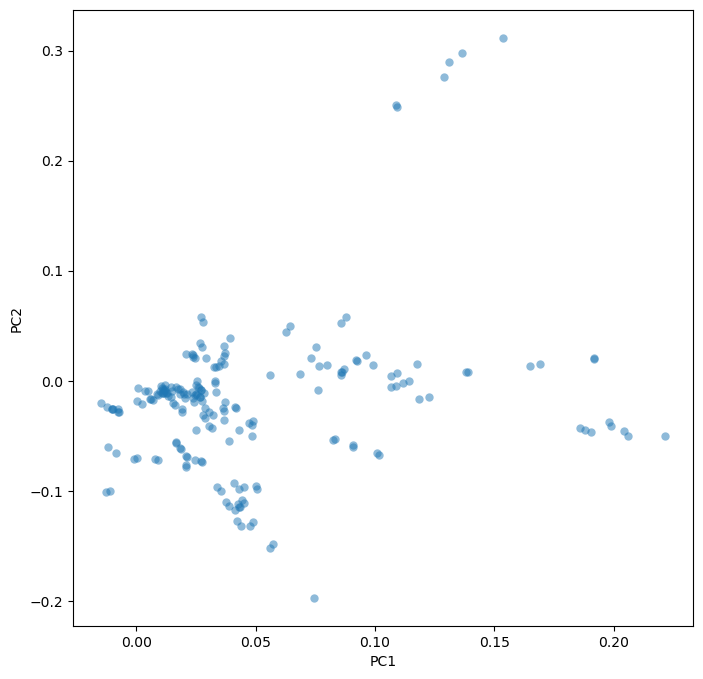

In [4]:
# Performing PCA
# df_scaled = pd.DataFrame(sklearn.preprocessing.scale(df.iloc[:, 3:-1]),columns = df.columns[3:-1]) 
pca = sklearn.decomposition.PCA(n_components=2)
pca.fit(df.iloc[:, 3:-1])
pca.feature_names_in_ = df.iloc[:, 3:-1].columns
plot_pca(pca)

- Try to use the experiment metadata to understand and remove outliers. Try labeling or coloring points by various metadata columns. Were any columns in the metadata useful for outlier removal? Note that `sklearn.preprocessing.LabelEncoder()` can be useful for transforming text strings to categories, and `plt.text` can be used to overlay labels with points.

In [5]:
# interesting metadata columns
ints_columns = ['Assay', 'Biosample term name', 
                'Biosample type']

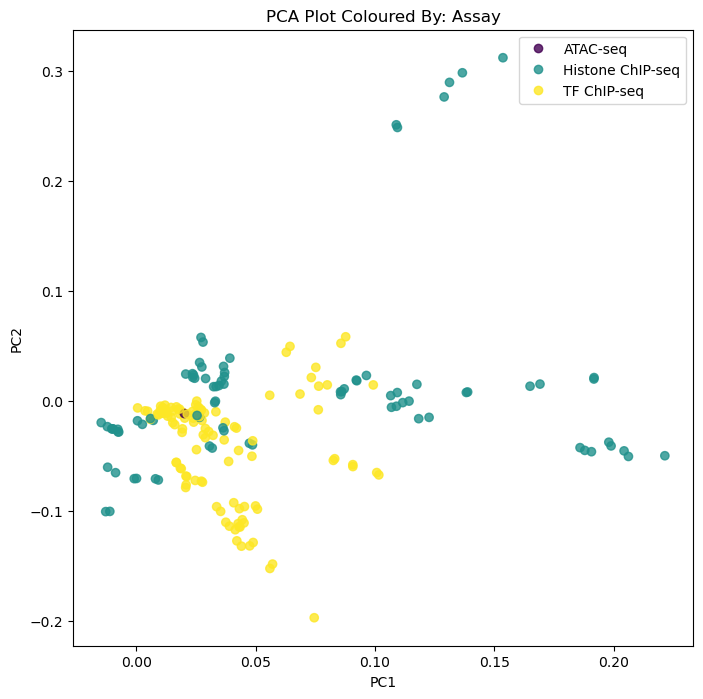

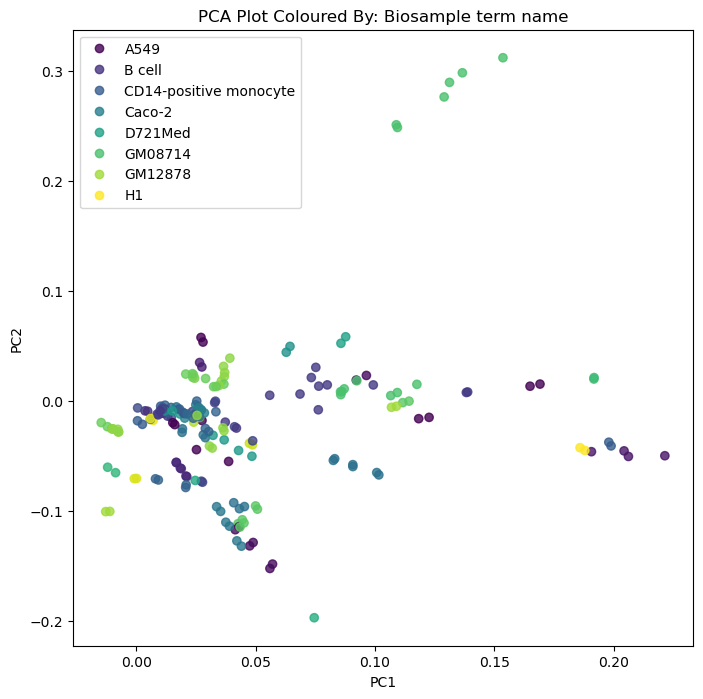

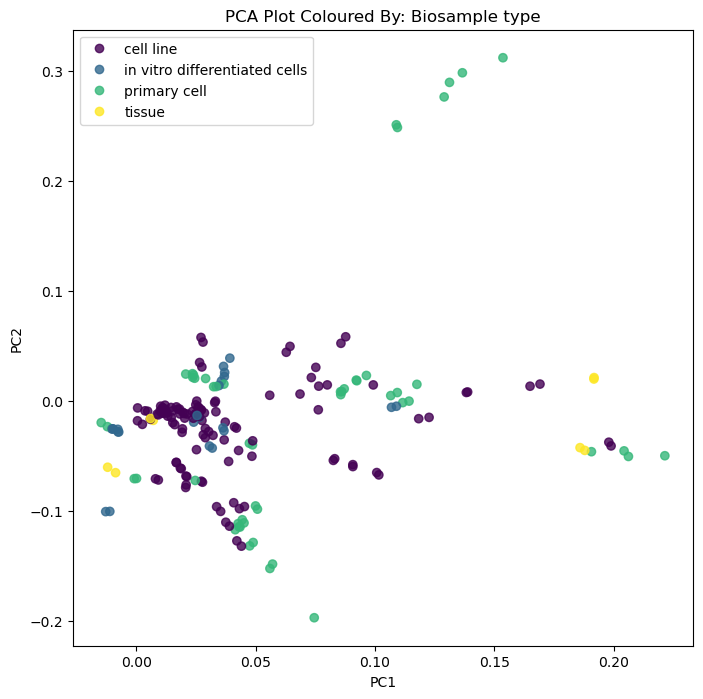

In [6]:
for col in ints_columns: 
    plot_pca(pca, bigwig_metadata, 
         metadata_label_column = col, 
         alpha = 0.8, lw = 1)

From the results shown above, the column "Biosample term name" and "Biosample type" could be useful for ourliers removal.

- Which Assays or Experiment Targets show broad vs narrow patterns? Is this consistent across cell types? Does this relate to the patterns seen in PCA? One way to investigate the characteristic scale is by computing the autocorrelation.


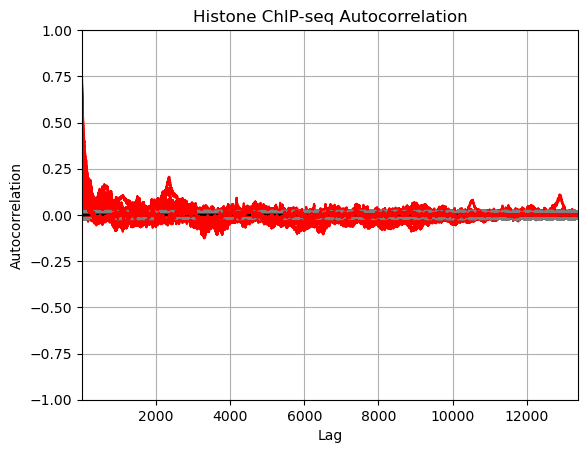

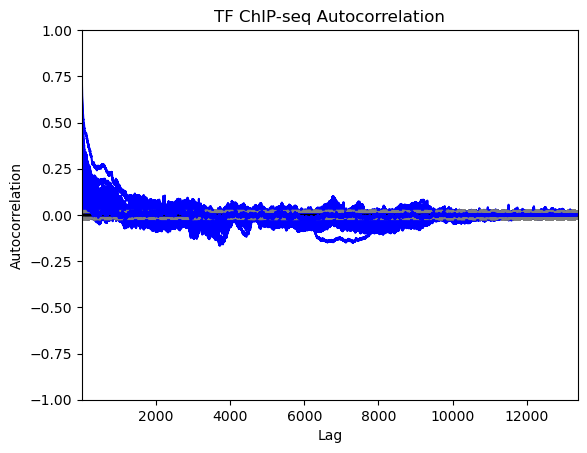

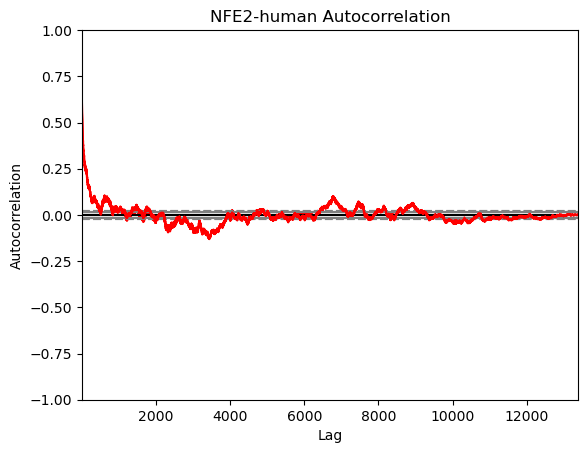

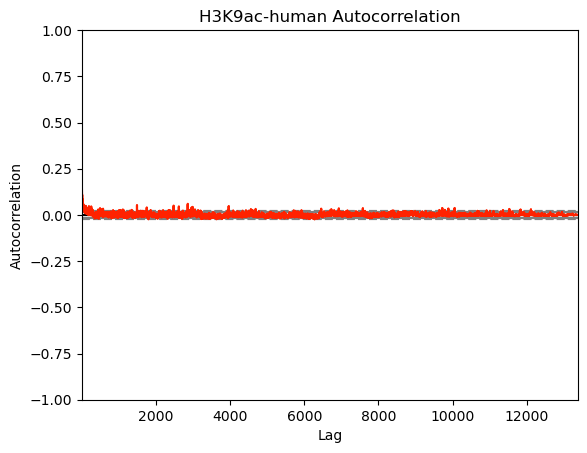

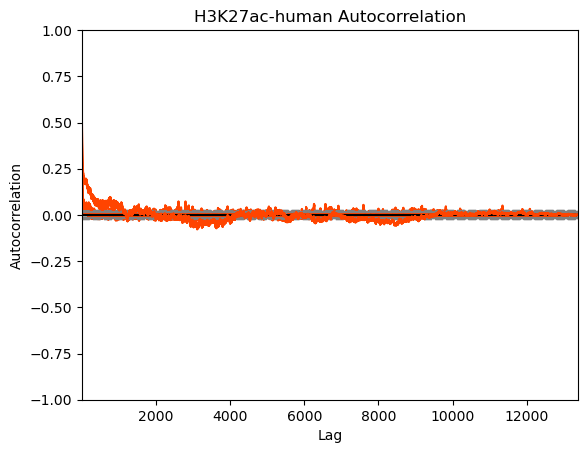

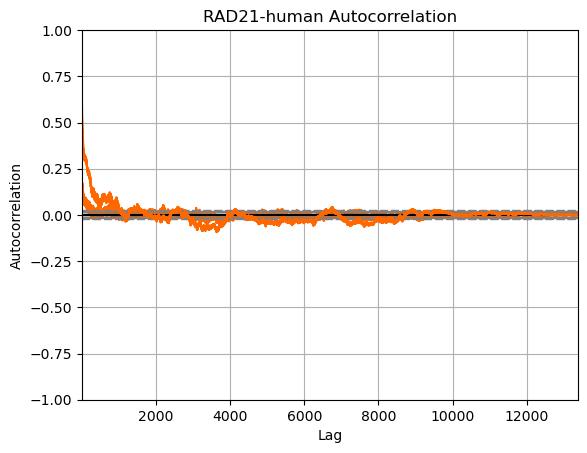

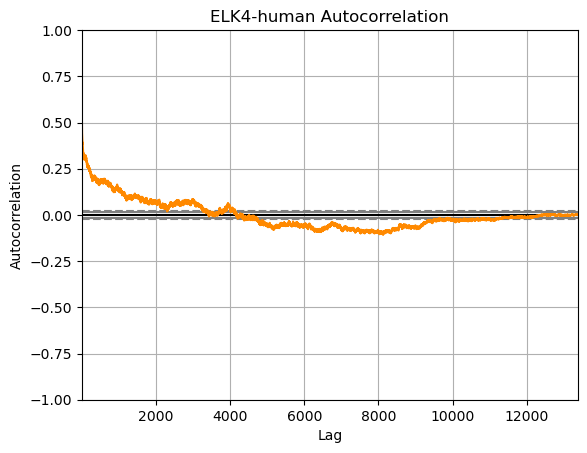

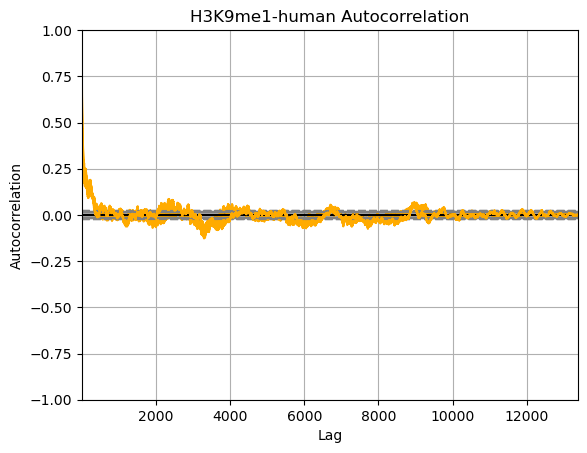

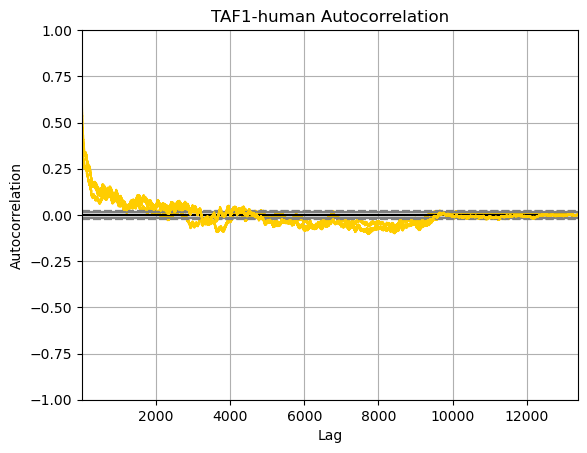

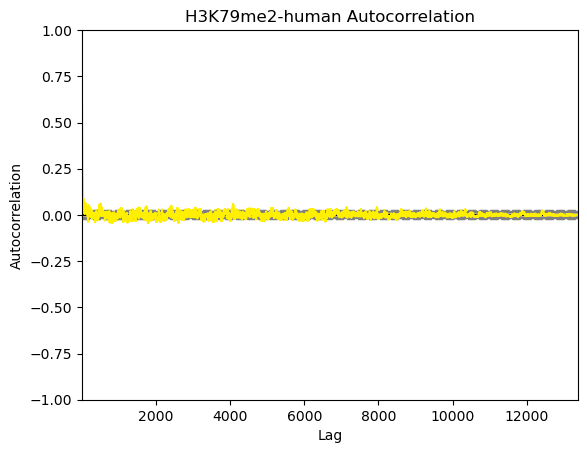

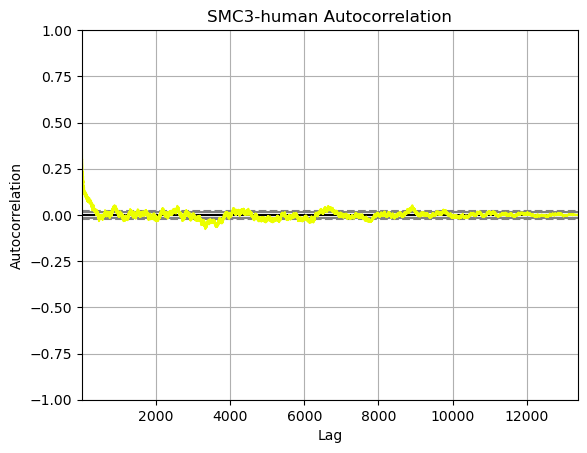

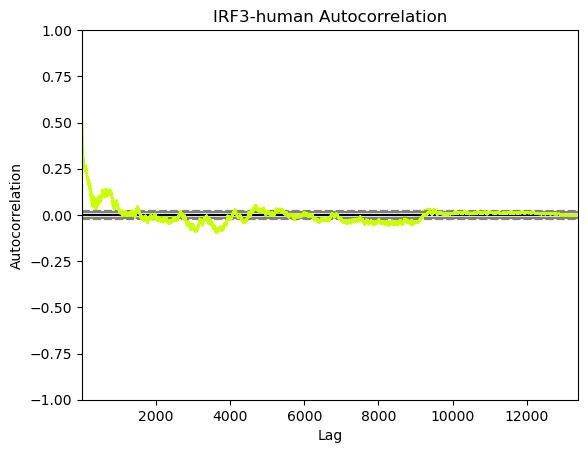

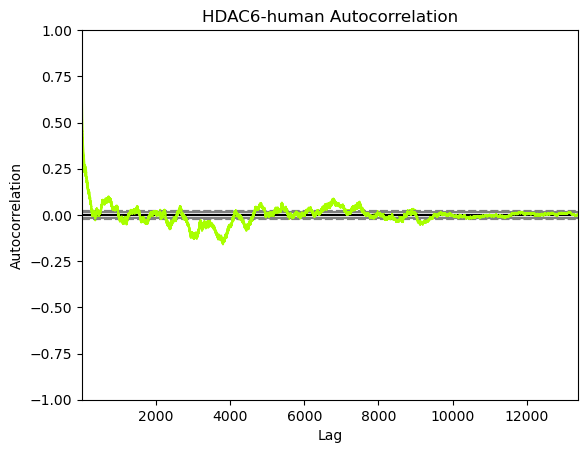

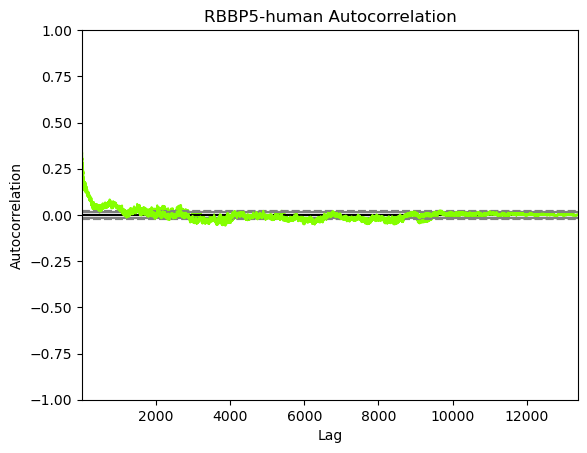

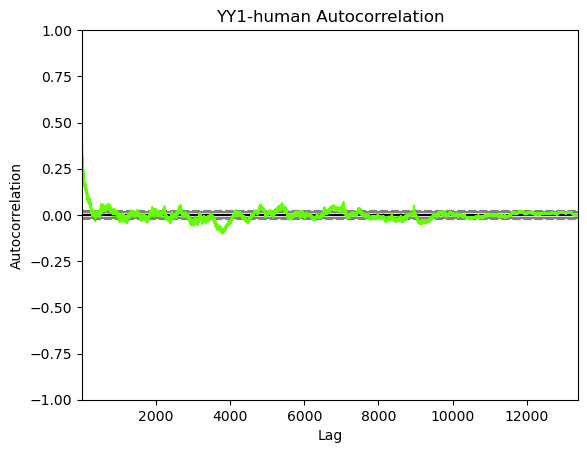

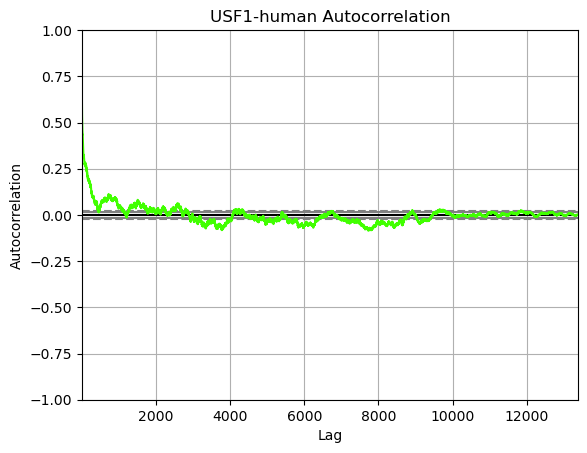

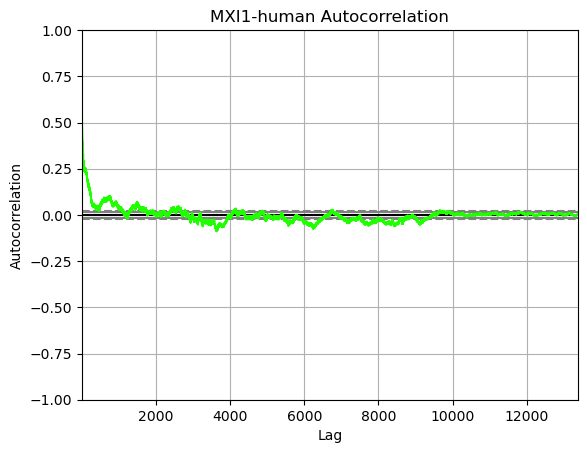

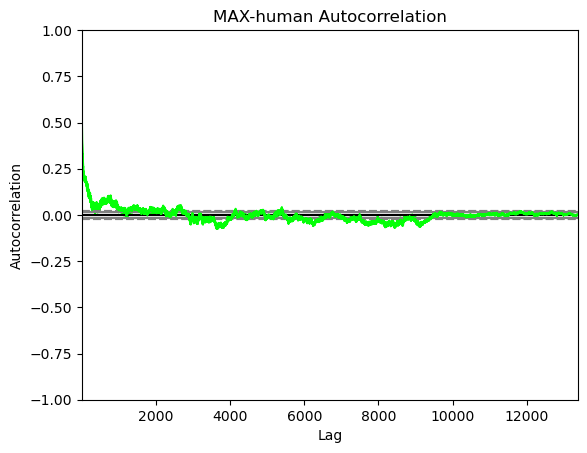

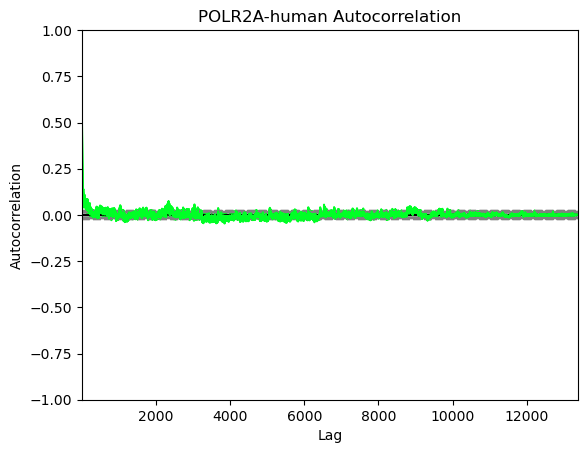

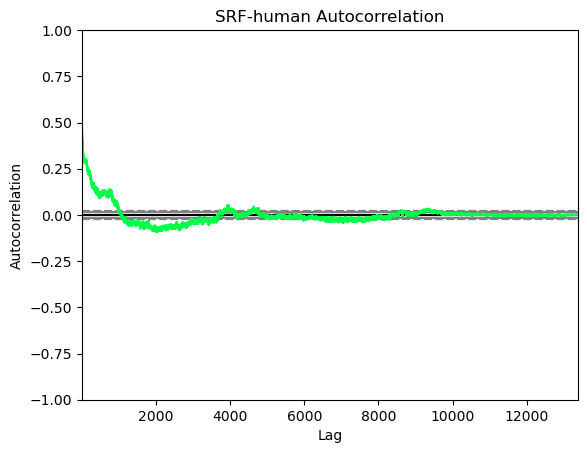

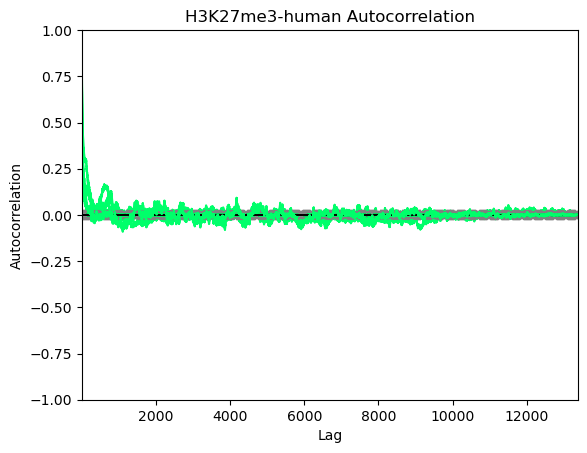

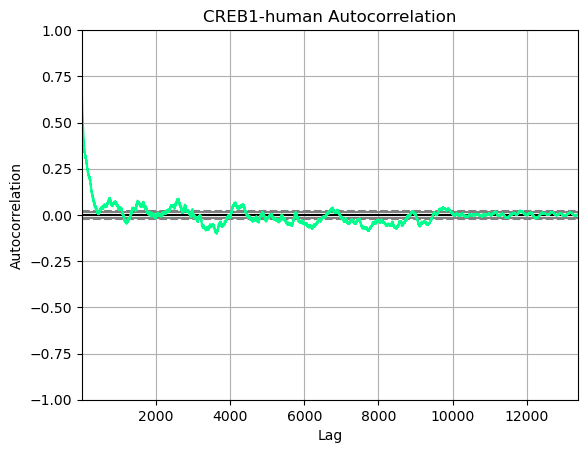

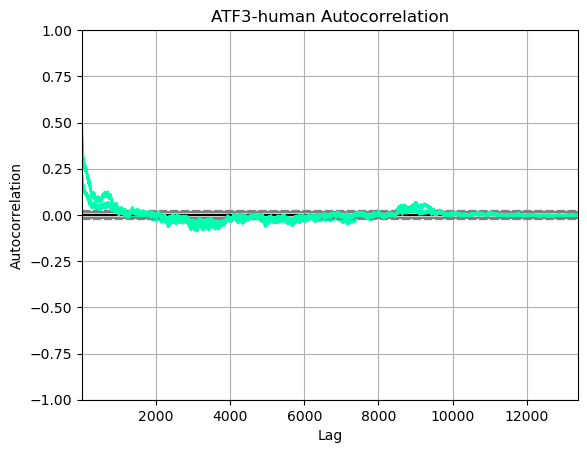

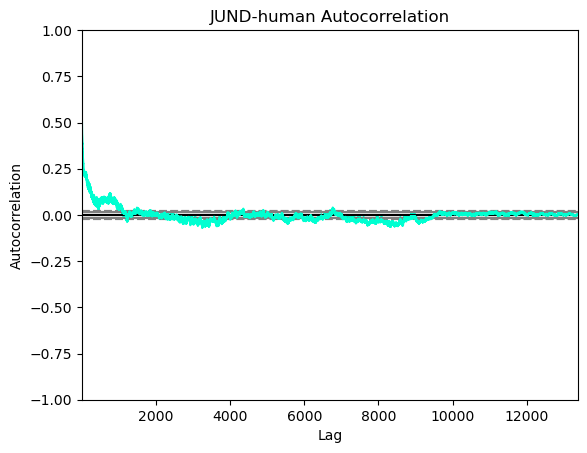

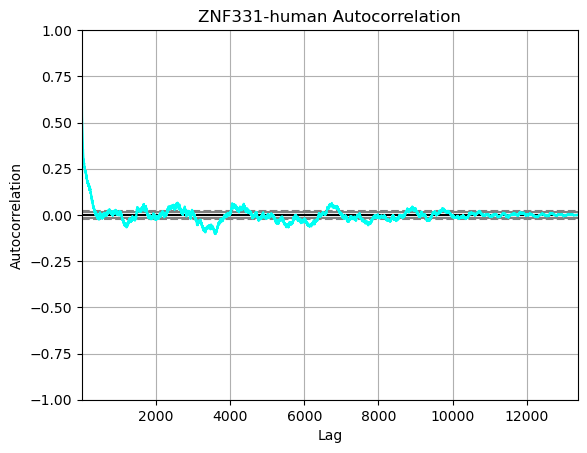

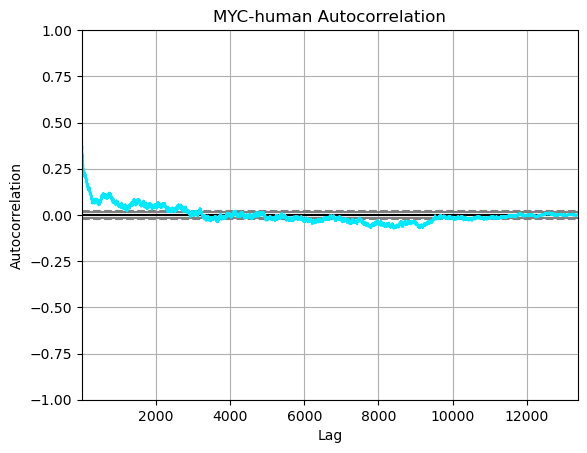

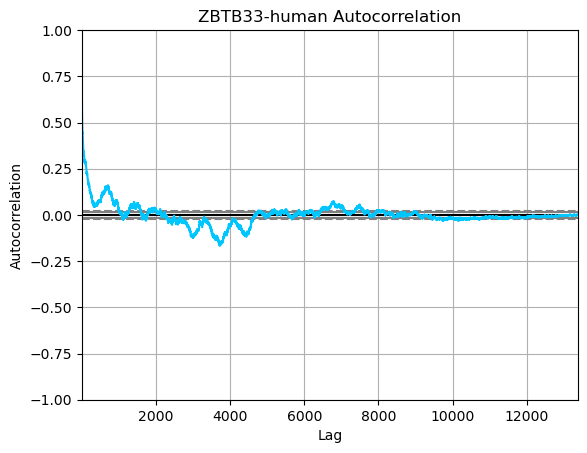

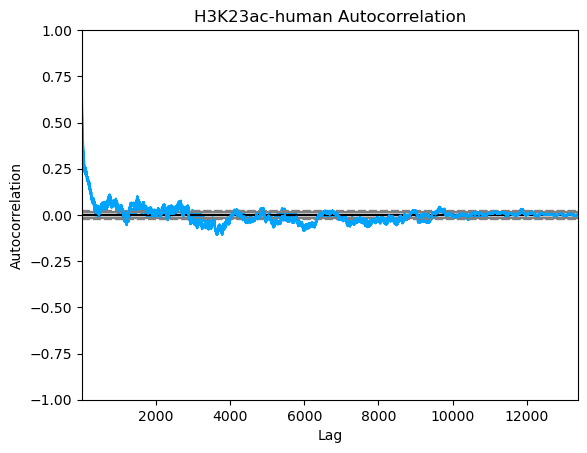

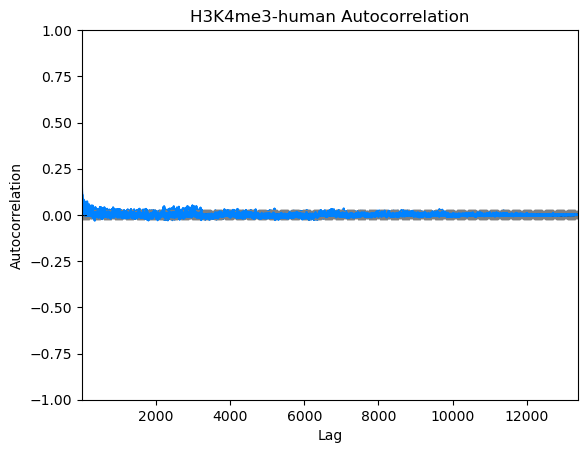

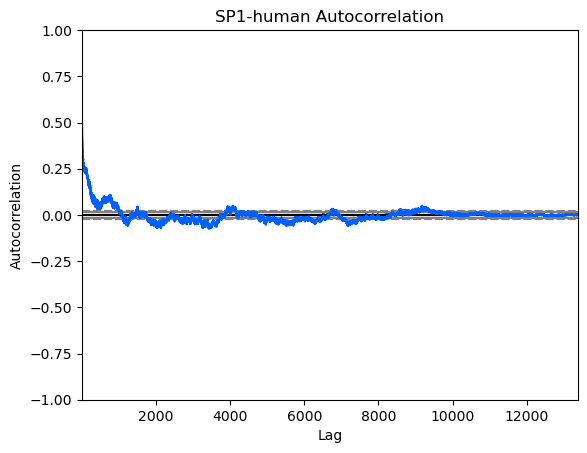

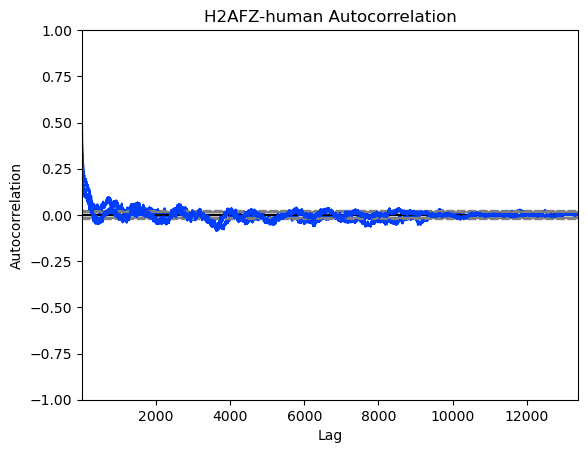

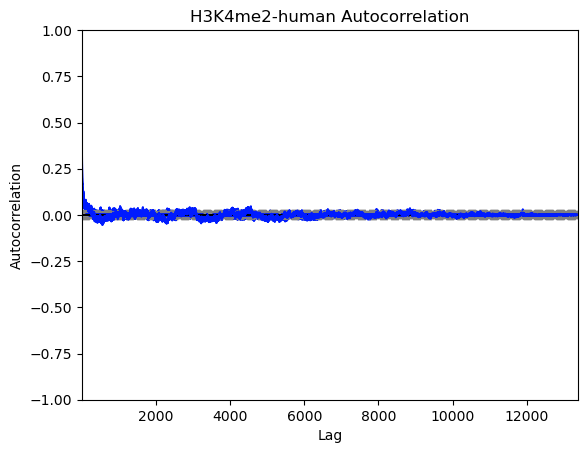

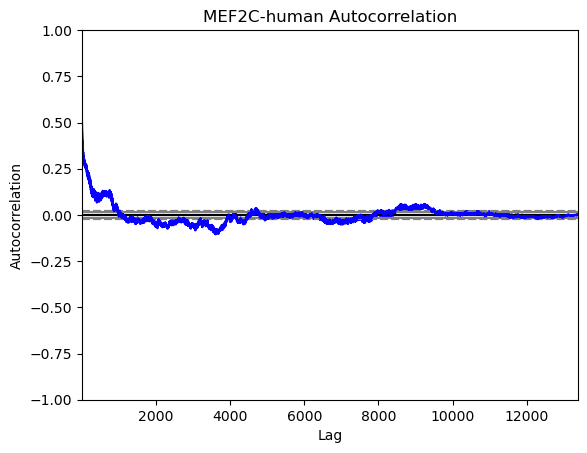

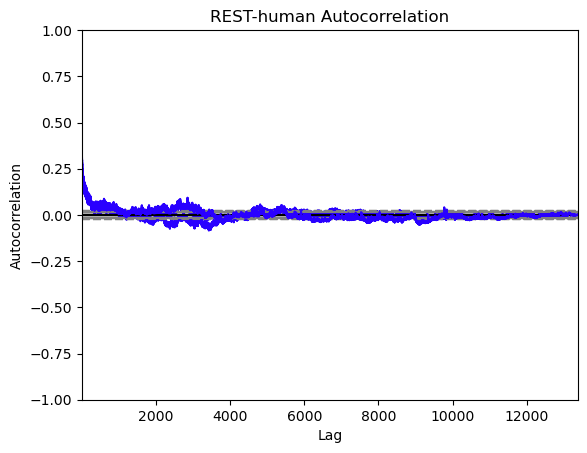

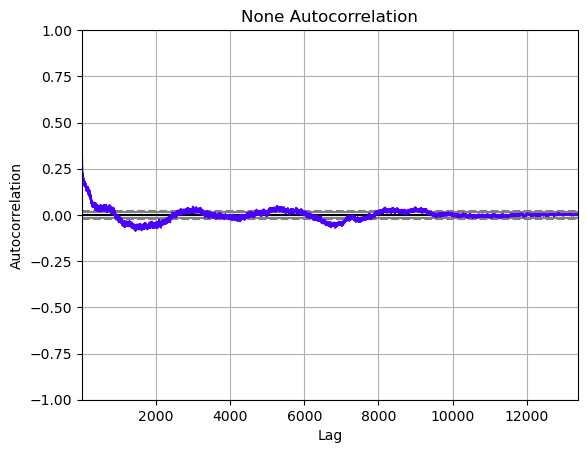

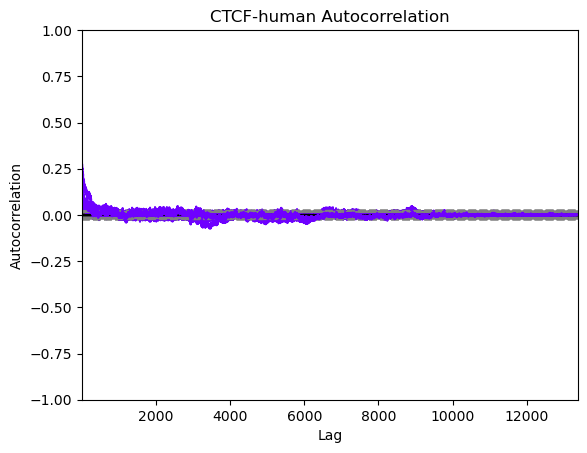

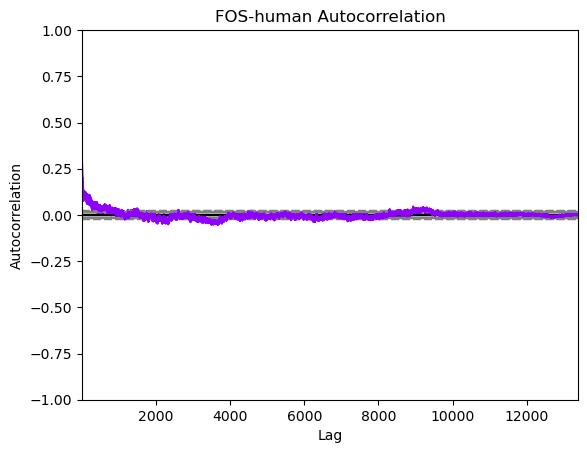

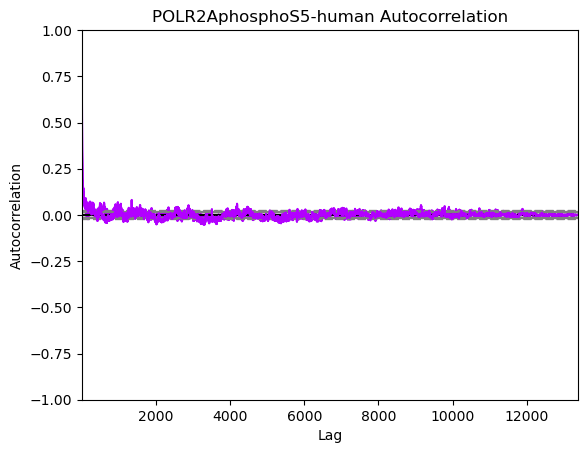

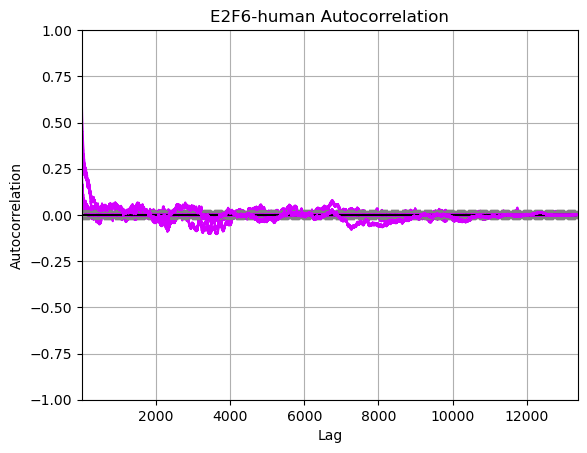

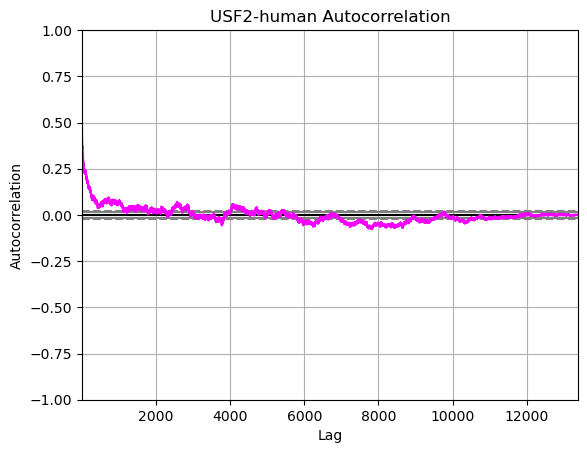

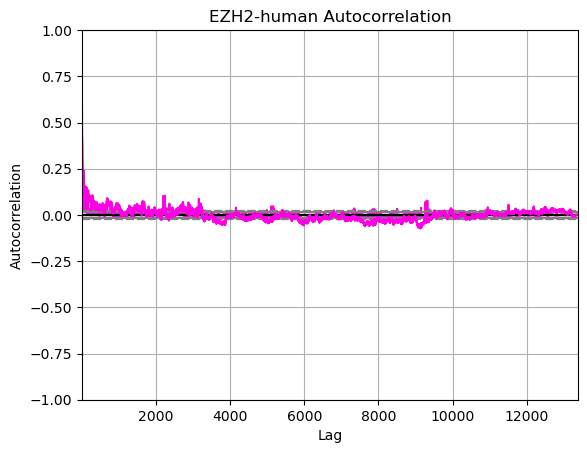

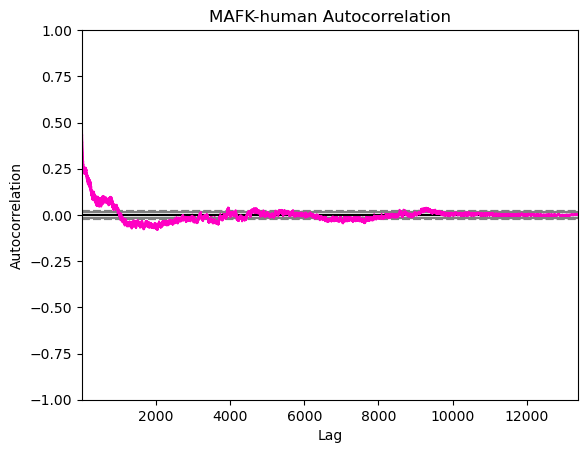

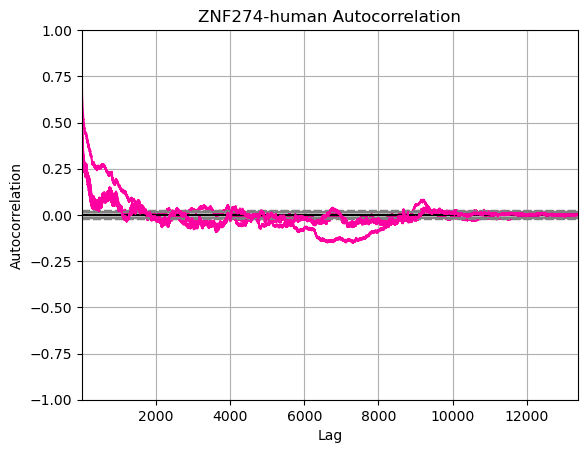

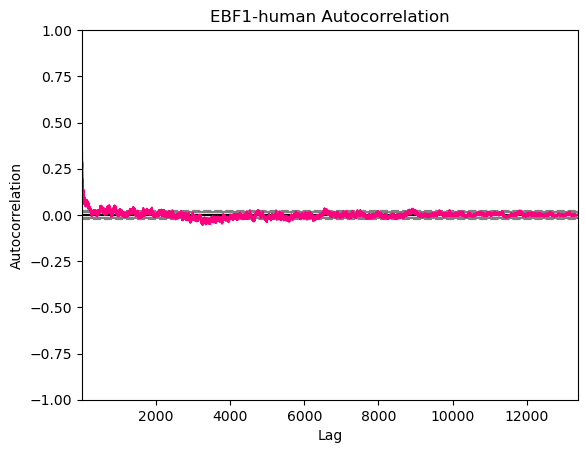

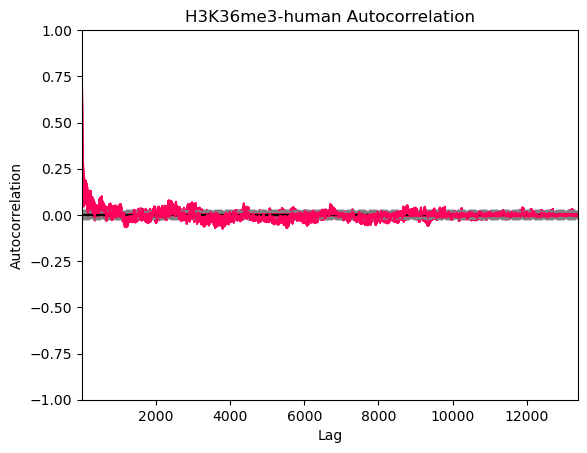

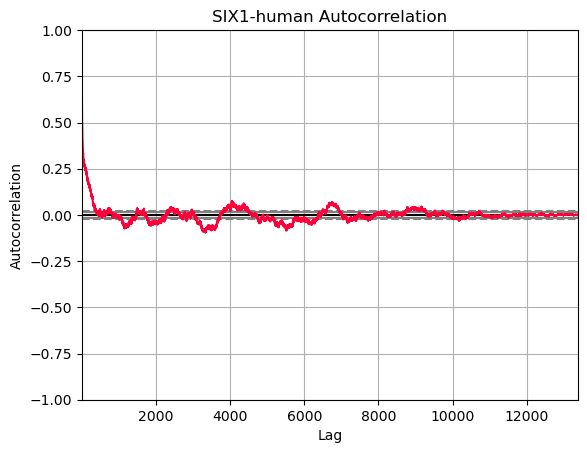

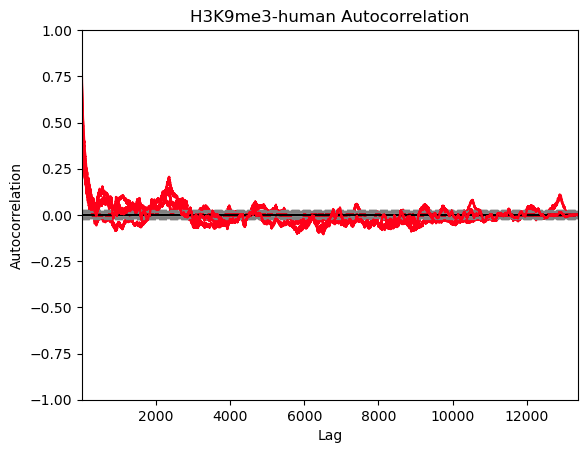

In [7]:
#grab the labes for assays and experiments
labels1 = [bigwig_metadata.query(
    "`File accession`==@ file_accession ").loc[:,'Assay'].values[0]
    for file_accession in pca.feature_names_in_]

labels2 = [bigwig_metadata.query(
    "`File accession`==@ file_accession ").loc[:,"Experiment target"].values[0]
    for file_accession in pca.feature_names_in_]


#Plot the autocorrelation for the two different assays
autocorrelation(labels1, df, 'Histone ChIP-seq', 'r')

autocorrelation(labels1, df, 'TF ChIP-seq', 'b')



#Now plot all of the autocorrelation plots for all the experiment targets
seen_targets=set()
for l in range(len(labels2)):
    if labels2[l] not in seen_targets:
        seen_targets.add(labels2[l])


i=0
cmap= plt.cm.get_cmap("hsv", len(seen_targets))
for target in seen_targets:
    autocorrelation(labels2, df, target,cmap(i))
    i=i+1

This part is a tad odd as well. It seems to me that all of the autocorrelation plots for the experiment targets are almost the exact same. It may point at some increadibly broad pattern across all of the targets, but I find it highly unlikely. If their autocorrelation starts so low, it is likely that they do not aggregate on a spatial level. But if we look at the first two plots that show the autocorrelation for histone assays and TF assays, we can see that the histone plot drops off much more quickly than the TF ones. This implies that the TF assaysa cluster more locally, while heterochromatin assays do so more broadly.

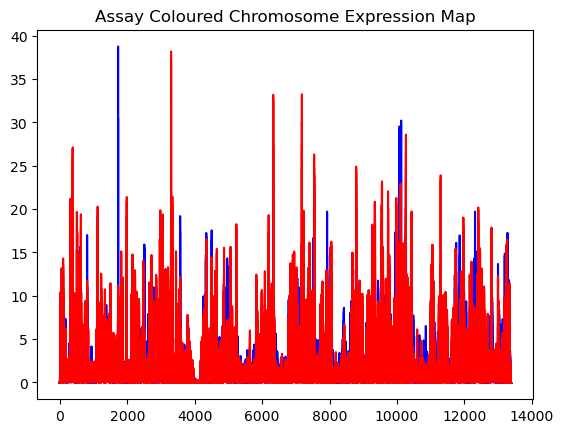

In [8]:
#Histone in front expression plot

df['midpos'] = (df.start + df.end)/2

for y in range(len(labels1)):
    if labels1[y] == 'TF ChIP-seq':
        df.iloc[:, 3+y].plot( c="b")

for p in range(len(labels1)):
    if labels1[p] == 'Histone ChIP-seq':
        df.iloc[:, 3+p].plot( c="r")


plt.title("Assay Coloured Chromosome Expression Map")

plt.show()


red= Histone ChIP-Seq
blue= TF ChIP-Seq

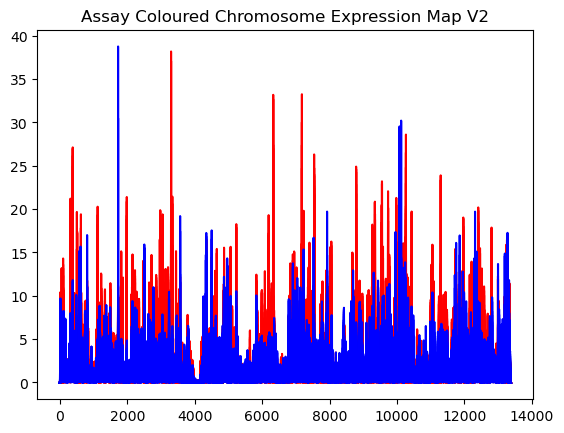

In [9]:
#TFs in front expression plot

for p in range(len(labels1)):
    if labels1[p] == 'Histone ChIP-seq':
        df.iloc[:, 3+p].plot( c="r")


for y in range(len(labels1)):
    if labels1[y] == 'TF ChIP-seq':
        df.iloc[:, 3+y].plot( c="b")



plt.title("Assay Coloured Chromosome Expression Map V2")

plt.show()

blue= TF 
red= Heterochromatin

While I am not totally sure why the is such a disparity when i just switch the order in which I adde data to the plot, but there is still relative information that holds value. We can see quite clearly that the expression correlates quite a bit! Hotspots from TF experimentation generally up in hotspots for chromatin experimentation. From there, if we look a little closer, we can also see that the TF experiments tend to spike and drop off more smoothly than the Heterochromatin peaks. This would indicate that the TFs are more spatially correlated than the chromatin ones are.

- Which "Experiment Targets" (e.g. histone marks or transcription factors) for which cell types are nearby in this PC1 vs PC2 space? Do any of these proximities have plausible biological interpretations? For example, are any polycomb-related factors in proximity? Illustrate this in a plot.


IndexError: list index out of range

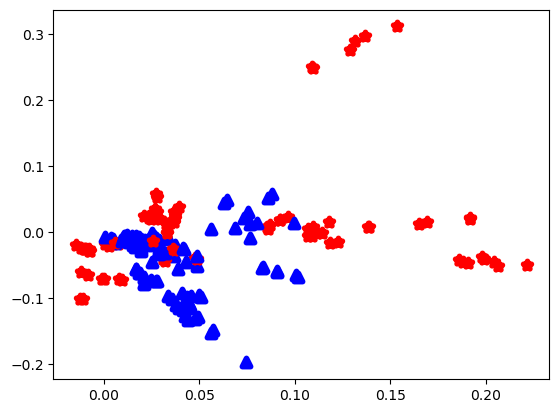

In [10]:
#Plot the assay/experiment target combo

plt.figure()

#grabs the assay data, and plots it first, to shadow the experiment targets
labels = [bigwig_metadata.query(
    "`File accession`==@ file_accession ").loc[:,'Assay'].values[0]
    for file_accession in pca.feature_names_in_]
for x in range(len(df.columns[3:])):
    if labels[x] == 'Histone ChIP-seq':
        plt.scatter(pca.components_[0][x], pca.components_[1][x], marker="*", linewidths=4, c="r")
    else:
        plt.scatter(pca.components_[0][x], pca.components_[1][x], marker="^", linewidths=4, c="b")


#grabs teh target data and plots it
labels = [bigwig_metadata.query(
    "`File accession`==@ file_accession ").loc[:,"Experiment target"].values[0]
    for file_accession in pca.feature_names_in_]
           
le = sklearn.preprocessing.LabelEncoder()
le.fit(labels)
labels = le.transform(labels) 
        

p = plt.scatter(pca.components_[0],
                pca.components_[1],
                c = labels)
if labels is not None: 
    plt.legend(handles = p.legend_elements()[0], 
                   labels = le.classes_.tolist())
    plt.title('PCA Plot Coloured By: '+ "tissue type and assay")
                   
plt.xlabel('PC1')
plt.ylabel('PC2')


plt.show

Red Star: Histone

Blue Trinagle: TFs


While slightly difficutl to read, the above plot overlays the TF and Histon markers, with the blue triangles being TF regulation, and the red stars being histone regulation. At a glance, the plot clearly shows that the TF experiments have a much strong tendency to congregate, possibly indicating that there is something going on there. WHen we consider the dimensions that we collapsed is purely a measure of where that expression was on the chromosome. As such, it is likely that one of the components measures spatial closeness, while the other might indicate measure of expression. So clusters are likely close in both of those regards. As such the tight cluster of TF expression likely indicates that there is some highly upregulated portion of this chromosome that is utterly swarmed by TFs. As we zoom in, other relationships come to light. Under the assumption that one of the dimensions mostly represents spatial closeness. From there, we can see that there is a consistent horizontal band at around -0.05 on PC2. If PC2 is spatially oriented, which I beleive, it could mean that there is a localization of both TFs and chormatin modifiers to facilitate them, all to greatly boost expression in the region. Or PC2 could be expression focused, which would imply that the band is a sort of normalized expression level seen all across chromosome 10. I find this more unlikely, as it is likely that chromatin modifiers need to accompany TFs spatially to help them bind. Zoomin in once again on this cluster of activity, we find a very close association, but notably little strict overlap, between CTCF/E2F6 and EZH2/ELK4. The former is characterized mostly by heterochromatin assays while the latter by TF assays. Seeing these different strains clustering around the same point means that these different strains may be using different methods to reach a similar level of expression in the same spot.

- How much does preprocessing matter? Try normalizing the variance per track and see if you arrive at similar or distinct conclusions. Try removing the region on chr10 mentioned above. Note that `sklearn.preprocessing.StandardScaler` could be useful for preprocessing. 


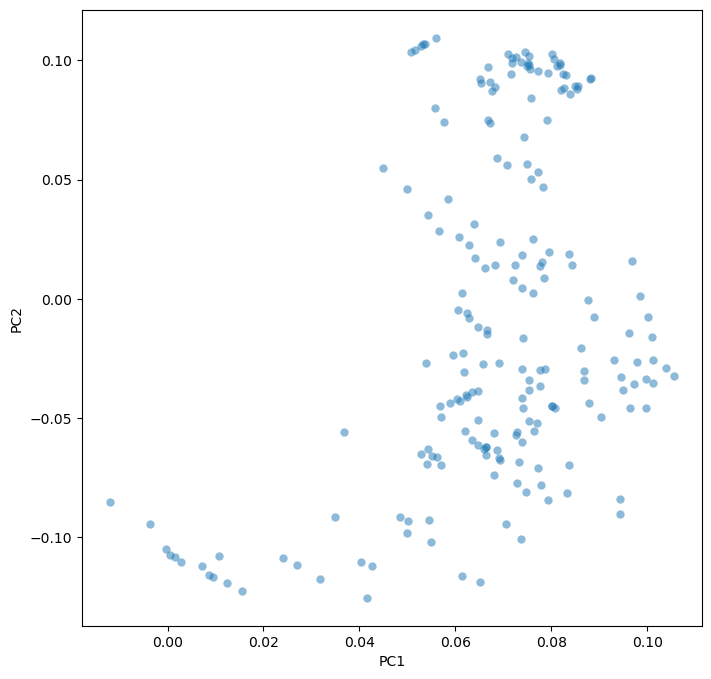

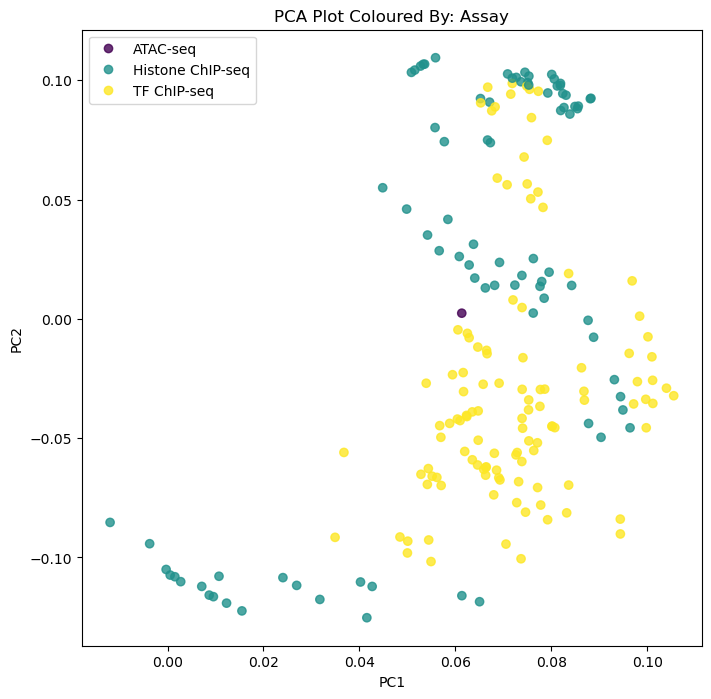

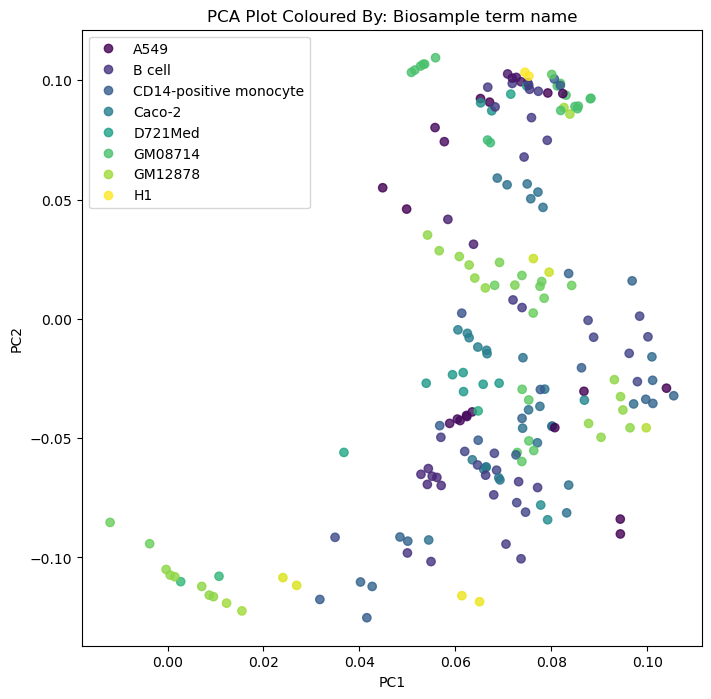

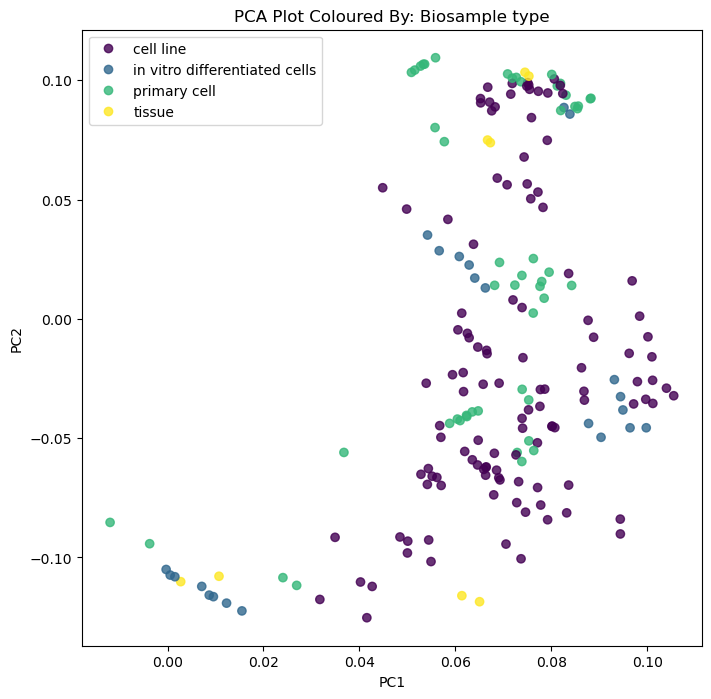

In [11]:
#preprocesses data, removes centromere region
df_scaled = pd.DataFrame(sklearn.preprocessing.scale(df.iloc[:, 3:-1]),columns = df.columns[3:-1]) 
df_scaled.drop(labels=range(400,415), axis=0, inplace=True)
pca = sklearn.decomposition.PCA(n_components=2)
pca.fit(df_scaled)
pca.feature_names_in_ = df_scaled.columns
plot_pca(pca)
for col in ints_columns: 
    plot_pca(pca, bigwig_metadata, 
         metadata_label_column = col, 
         alpha = 0.8, lw = 1)

These changes prove to be an effective method for preprocessing. Seeing as how differently the points organize themselves, as well as offering a higher fidelity to the type of clustering going on. We still see a consistent band happening, but now it occurs horizontally, while also curving in towards the origin. One of these band probabaly indicates the consistently highly expressed areas, while the curve towards the origin might indicate the base level of expression for the chromosome.

- How many PCs are needed to explain 90% of the variance in the data? Illustrate this with a scree plot (https://en.wikipedia.org/wiki/Scree_plot). 


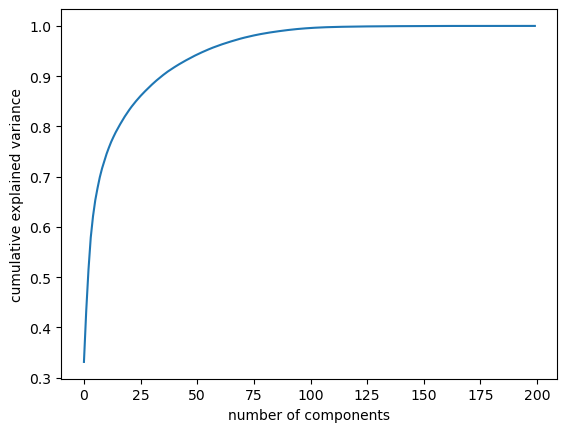

In [12]:
df_scaled = pd.DataFrame(sklearn.preprocessing.scale(df.iloc[:, 3:-1]),columns = df.columns[3:-1]) 
pca = sklearn.decomposition.PCA().fit(df_scaled)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

From the plot shown above, about 30 PCs are needed to explain 90% of the data variance.

- How different is the dimensionality reduction into two dimensions for PCA from that obtained using MDS (multi-dimensional scaling)? What methods could be used to determine the similarity? Illustrate with a plot.


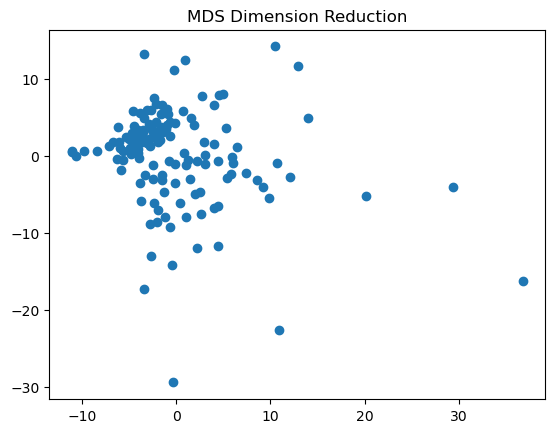

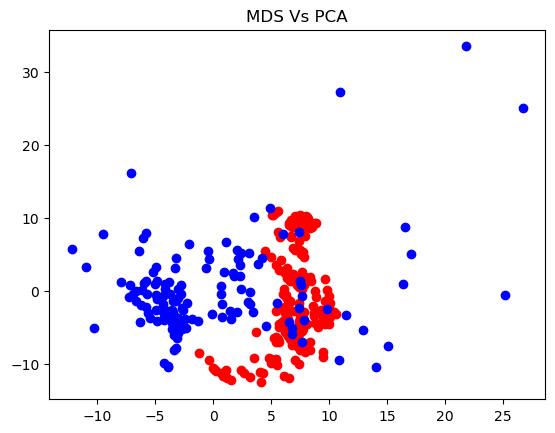

In [13]:
mds=sklearn.manifold.MDS(n_components=2, n_init=35, max_iter=600)
col_num=df.iloc[:, 3:-1].shape[1]
random_indices= np.random.choice(col_num, size=int(col_num/1.5), replace=False)
mdsTransform=mds.fit_transform(df.iloc[random_indices, 3:-1])
plt.scatter(mdsTransform[:,0], mdsTransform[:, 1] )
#for x in range(len(mdsTransform[:, 1])):
#    plt.text(mdsTransform[:,0][x], mdsTransform[:, 1][x], str(x))
plt.title("MDS Dimension Reduction")
plt.show()
##
## Comparing similairty
##

#Visual Representation

plt.figure()
p = plt.scatter(pca.components_[0]*100,
                pca.components_[1]*100,
                c="r")

mds=sklearn.manifold.MDS(n_components=2, n_init=35, max_iter=600)
col_num=df.iloc[:, 3:-1].shape[1]
random_indices= np.random.choice(col_num, size=int(col_num/1.5), replace=False)
mdsTransform=mds.fit_transform(df.iloc[random_indices, 3:-1])
plt.scatter(mdsTransform[:,0], mdsTransform[:, 1] , c="b")
#for x in range(len(mdsTransform[:, 1])):
#    plt.text(mdsTransform[:,0][x], mdsTransform[:, 1][x], str(x))
plt.title("MDS Vs PCA")
plt.show()
#Quantitative representation



Multi-dimensional scaling is definitely different from PCA. Instead of having a maximizing function that is trying its best to explain the variance going with only k dimensions, MDS has a minimization function which attempts to maintain the distance between all points as much as possible. When running the MDS algorithm to generate the first plot above, I foudn that each run, regarless of the paramaters I used, resulted in the clustering localizing slgihtly differently. Some patterns where consistent however, such as the points fanning out upwards while there is a single dense cluster lower down. After scaling up the PCA plot (red) by a factor of a hundred, and overlapping it with the MDS one (blue), I found the that the main clusters coincide wuite well, but the points tend to fan out in different directions. I am unsure as to why exactly this happens, but it may be an artifact of the dichotomoy between maximize and minimize. Similar to primals and duals in algorithmic theory, they approach the problem from different directions, but optimize to the same place.

- Would non-negative matrix factorization (https://en.wikipedia.org/wiki/Non-negative_matrix_factorization) be a useful method to use for this dataset? Why or why not?  (No plots needed for this question).


Upon doing some further research I found that Non-negative matrix factorization already has precednt with regards to operating on expression data. It does however present quite differently. Non-negative matria factorization would essentially factor our original matrix of expression levels for different regions on chromosome 10 into 2 different matricies. One, called the component matrix, which has dimensions k x n, where n is the number of dimensions and k is the number of dimensions being reduced to. The second is called the mixing matrix, which is an m x k matrix where m is the number of elements in the original data set. The is the often focused in this instance, as it gives k dimensions to each element. There is a proof that shows that NMF is identical to k-means clustering when using certain parameters. The classical representation I found was a 2012 paper by Leo Taslaman and Bjorn Nilsson which had a matrix holding the expression data between genes and different experiments. We can reconfigure this method to view each individual as an experiment, and each portion of the chromosome as a seperate gene. Then similar to our PCA, we set k to 2, then then plot those two dimensions for each entry. I do think that this has some drawback when compared to PCA, as it does not normally have an optimization function, so there usually many correct answer for the factorization. There are methods that help mitigate this, but I do think that it makes NMF slightly less suited to dimnesionality reduction as compared to clustering.